# Results

In [204]:
library('ggplot2')
source('get_expected_pval_and_equiv_z.R')
source('multiplot.R')
source('plot_lib.R')

#### Load data from the CSV files

In [171]:
allsimudat_btw0 <- load_data_from_csv('^test1_.*btw0_.*')
allsimudat_btw1 <- load_data_from_csv('^test1_.*btw1_.*')
allsimudat <- rbind(allsimudat_btw0, allsimudat_btw1)

In [205]:
allsimudat2_btw0 <- load_data_from_csv('^test2_.*btw0_.*')
allsimudat2_btw1 <- load_data_from_csv('^test2_.*btw1_.*')
allsimudat2 <- rbind(allsimudat2_btw0, allsimudat2_btw1)

In [206]:
unique(allsimudat2_btw0$glm)

[1] 2

In [207]:
allsimudat3_btw0 <- load_data_from_csv('^test3_.*btw0_.*')
allsimudat3_btw1 <- load_data_from_csv('^test3_.*btw1_.*')
allsimudat3 <- rbind(allsimudat3_btw0, allsimudat3_btw1)

### 1. Robustness to units mismatch

We look how contrast-based methods are affected by the units issue.

In [208]:
con_methods <- c("megaMFX","megaRFX","permutCon", "megaFFX_FSL")
con_data_1 <- subset(allsimudat, is.finite(expectedz) & expectedz>0 &  methods %in% con_methods)
con_data_2 <- subset(allsimudat2, is.finite(expectedz) & expectedz>0 & methods %in% con_methods)
con_data_3 <- subset(allsimudat3, is.finite(expectedz) & expectedz>0 & methods %in% con_methods)

##### Plots

###### Units mismtach

We look at the best case scenario for each contrast-based method:
 - MFX GLM: τ2 ≠ 0 -> τ2 = 1
 - RFX GLM: σ2<<τ2 or σ2/n constant for all studies -> σ2=1/2
 - Contrast Permutation: anything
 - FFX GLM: τ2 = 0

In [222]:
best_con_data_1 <- subset(con_data_1, 
    ((methods %in% c("megaMFX","megaRFX","permutCon") & Between==1) |
    ((methods %in% c("megaFFX_FSL") & Between==0))) & 
    Within==5 & nStudies==25)
best_con_data_2 <- subset(con_data_2, 
    ((methods %in% c("megaMFX","megaRFX","permutCon") & Between==1) |
    ((methods %in% c("megaFFX_FSL") & Between==0))) & 
    Within==5 & nStudies==50)
best_con_data_3 <- subset(con_data_3, 
    ((methods %in% c("megaMFX","megaRFX","permutCon") & Between==1) |
    ((methods %in% c("megaFFX_FSL") & Between==0))) & 
    Within==5 & nStudies==50)

#### One-sample tests

Warning message:
“Removed 536 rows containing missing values (geom_path).”

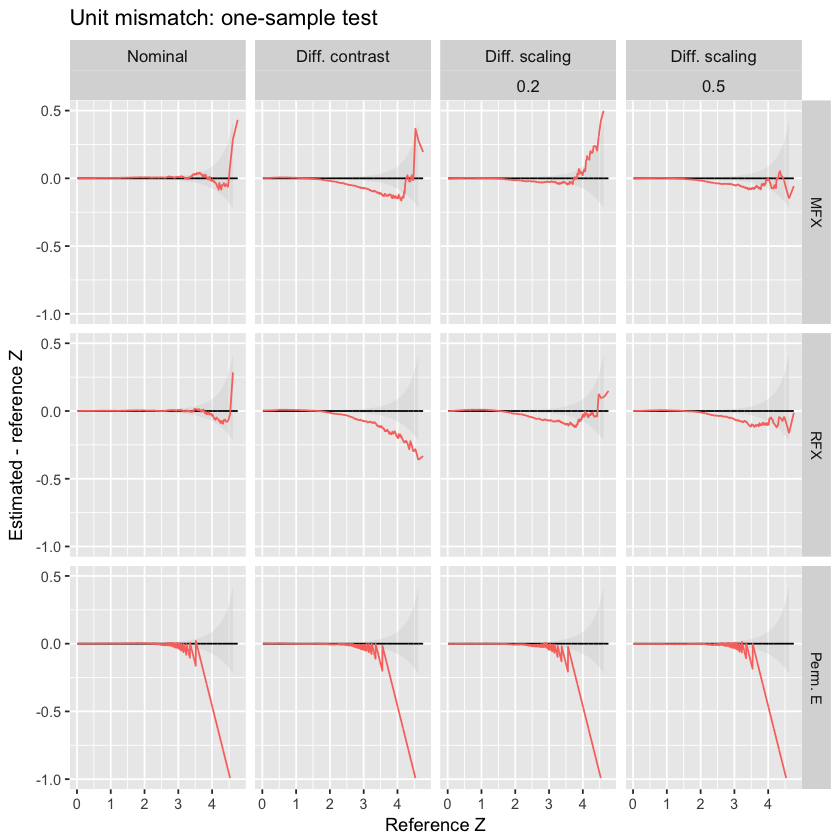

In [225]:
source('plot_lib.R')
plot_unit_mismatch(best_con_data_1, 'one-sample test', mult=FALSE, single=TRUE)

#### Two-sample tests

Warning message:
“Removed 1118 rows containing missing values (geom_path).”

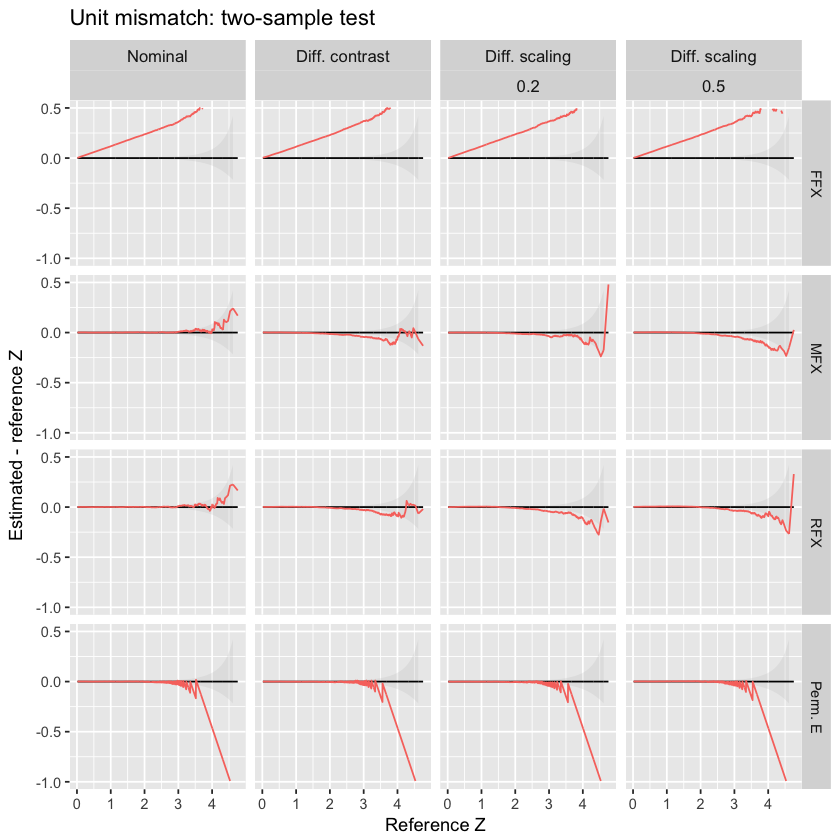

In [226]:
plot_unit_mismatch(best_con_data_2, 'two-sample test', mult=FALSE, single=TRUE)

#### Unbalanced two-sample tests)

Warning message:
“Removed 1297 rows containing missing values (geom_path).”

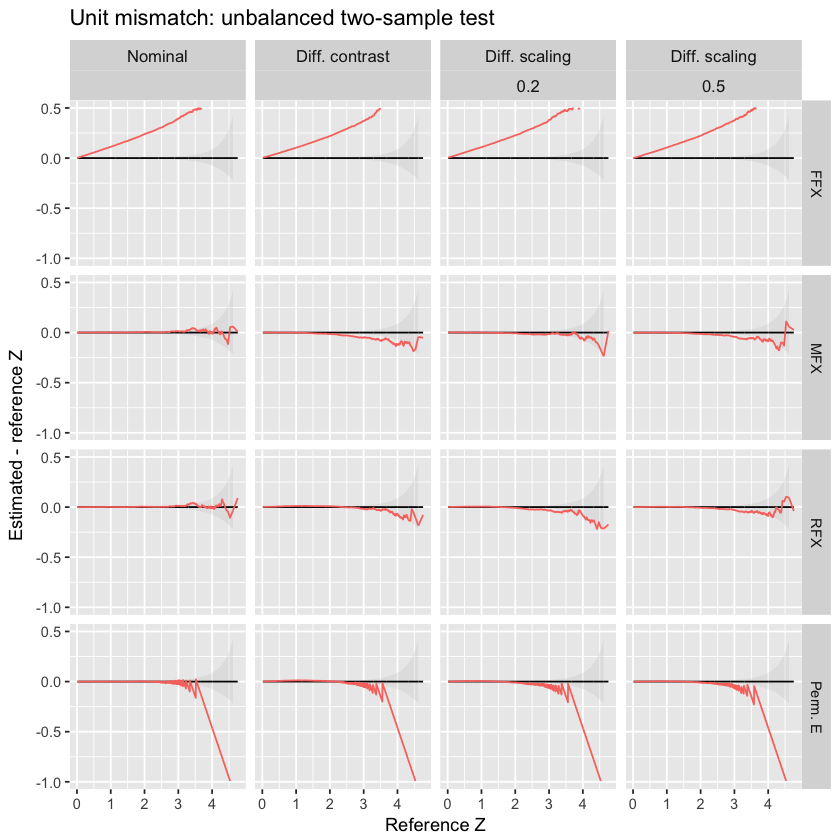

In [227]:
plot_unit_mismatch(best_con_data_3, 'unbalanced two-sample test', mult=FALSE, single=TRUE)